In [1]:
import numpy as np
import pylab as plt
import matplotlib
from scipy.signal import welch
import seaborn as sns
import types
import time

import tensorflow as tf
import tensorflow_probability as tfp


plt.style.use('ggplot')

# Utility function definitions

In [2]:
# sum the oscillators into one signal
# phiMatrix = phases
# A = amplitudes
def sumOsc(phiMatrix, A):
    A = np.resize(A, (1, len(A)))
    return A.dot(np.sin(phiMatrix)).sum(0)

# ODE function and Jacobian

In [3]:
def kuramoto_ODE_tf(t,y):
    a = tf.linalg.matvec(K_tf/nOsc, tf.reduce_sum(tf.sin(y - y[:,None]),1))
    #a = (K_tf/nOsc) * tf.reduce_sum(tf.sin(y - y[:,None]),1)
    return W_tf + a

def kuramoto_jac_tf(t,y):
    a = tf.cos(y[:,None] - y) - tf.eye(len(y), dtype=tf.double)
    b = -tf.reduce_sum(tf.cos(y - y[:,None]), 1) + tf.ones(len(y), dtype=tf.double)
    c = tf.linalg.diag(b)
    return (K_tf/nOsc) * (a + c)

def kuramoto_ODE_timeDependent_tf(t,y):
    K_tf = couplingMatrix(t)
    a = tf.linalg.matvec(K_tf/nOsc, tf.reduce_sum(tf.sin(y - y[:,None]),1))
    return W_tf + a

def kuramoto_jac_timeDependent_tf(t,y):
    K_tf = couplingMatrix(t)
    a = tf.cos(y[:,None] - y) - tf.eye(len(y), dtype=tf.double)
    b = -tf.reduce_sum(tf.cos(y - y[:,None]), 1) + tf.ones(len(y), dtype=tf.double)
    c = tf.linalg.diag(b)
    return (K_tf/nOsc) * (a + c)

def couplingMatrix(t):
    
    K1 = .001 * tf.eye(nOsc, dtype=tf.double)
    K2 = 40 * tf.eye(nOsc, dtype=tf.double)
    
    if t < 15.:
        return K1
    elif t < 20.:
        alpha = t - 15.
        return (alpha * K2) + ((1 - alpha) * K1)
    elif t < 25.:
        alpha = t - 20.
        return (alpha * K1) + ((1 - alpha) * K2)
    elif t >= 25.:
        return K1

# Set the parameters for the Kuramoto model.

In [4]:
# set these simulation parameters
nOsc = 200
upperTimeBound = 40
dt = 0.01

# Defining time array
numTimePoints = int(upperTimeBound/dt) + 1
T = np.linspace(0, upperTimeBound, numTimePoints)
 
# Y0, W, K, A are initial phase, intrinsic freq, amplitude and
# coupling K matrix (or list of K matricies) respectively 
# (note K can be arbitary, in particular inhomogeneous, in contrast to Kuramoto's original model)

Y0 = np.random.uniform(low=0.0, high=2*np.pi, size=nOsc)
W = 2 * np.pi * np.random.normal(loc=20, scale=2, size=nOsc)
A = np.ones(nOsc)

W_tf = tf.constant(W)
K_tf = tf.constant(100. * tf.eye(nOsc, dtype=tf.double))

# Numerically solve the model and plot the results.

In [5]:
completeTimeFlag = True

if completeTimeFlag:
    solution_times = T
    ode_fn = kuramoto_ODE_timeDependent_tf
    jacobian_fn = kuramoto_jac_timeDependent_tf
else:
    solution_times=tfp.math.ode.ChosenBySolver(final_time=upperTimeBound)
    ode_fn = kuramoto_ODE_tf
    jacobian_fn = kuramoto_jac_tf


print("Solving ODEs...")
start = time.time()

results = tfp.math.ode.BDF().solve(ode_fn=ode_fn, 
                            initial_time=0, 
                            initial_state=Y0, 
                            solution_times=solution_times, 
                            jacobian_fn=jacobian_fn)
print("Finished.")
print("Seconds elapsed: {}".format(time.time() - start))

odePhi = results.states.numpy().T
times = results.times.numpy()
orderParameterAbs = [np.abs(np.exp(odePhi[:,i] * (0+1j)).sum())  for i in range(odePhi.shape[1])]

Solving ODEs...
Finished.
Seconds elapsed: 519.5277006626129


In [33]:
odePhi.shape

(200, 4001)

In [31]:
np.save('odePhi',odePhi)

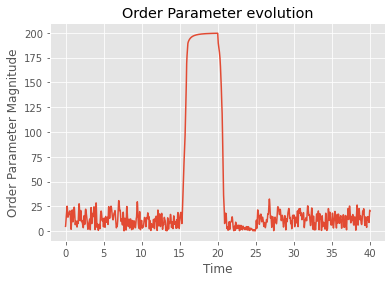

In [ ]:
plt.figure()
plt.plot(times, orderParameterAbs)
plt.ylabel('Order Parameter Magnitude')
plt.xlabel('Time');
plt.title('Order Parameter evolution');

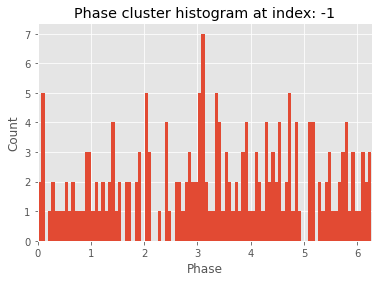

In [ ]:
index = -1

plt.figure()
plt.hist(np.mod(odePhi[:,index], 2*np.pi),100)
plt.xlim([0, 2 * np.pi])
plt.xlabel('Phase');
plt.ylabel('Count');
plt.title('Phase cluster histogram at index: {}'.format(index))
plt.show()

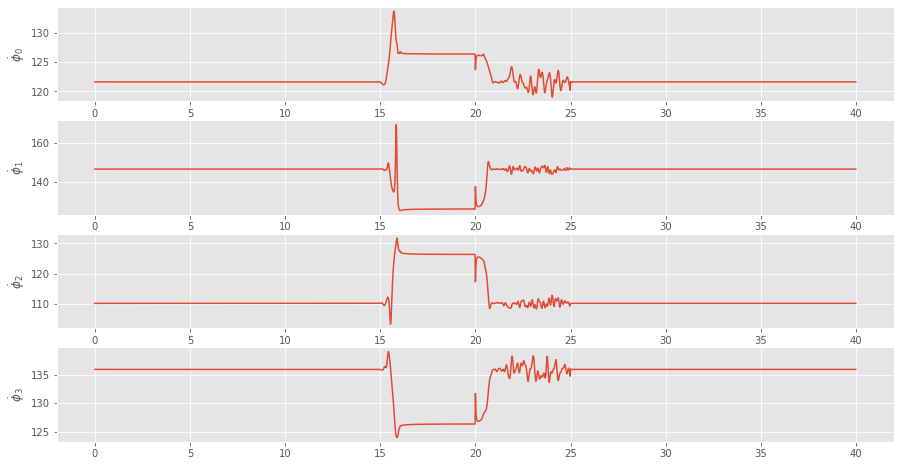

In [ ]:
# Plotting response
if completeTimeFlag:
    oscList = range(4)
    
    angularVelocity = np.diff(odePhi)/dt
    lenPlot = len(oscList)
    plt.figure(figsize=(15,2 * lenPlot))
    for i, osc in enumerate(oscList):
        plt.subplot(lenPlot, 1, 1+i)
        plt.plot(T[:-1], angularVelocity[osc])
        plt.ylabel("$\dot\phi_{%i}$" %(osc))

# Figure 3a.1 Plot the sum of the oscillators

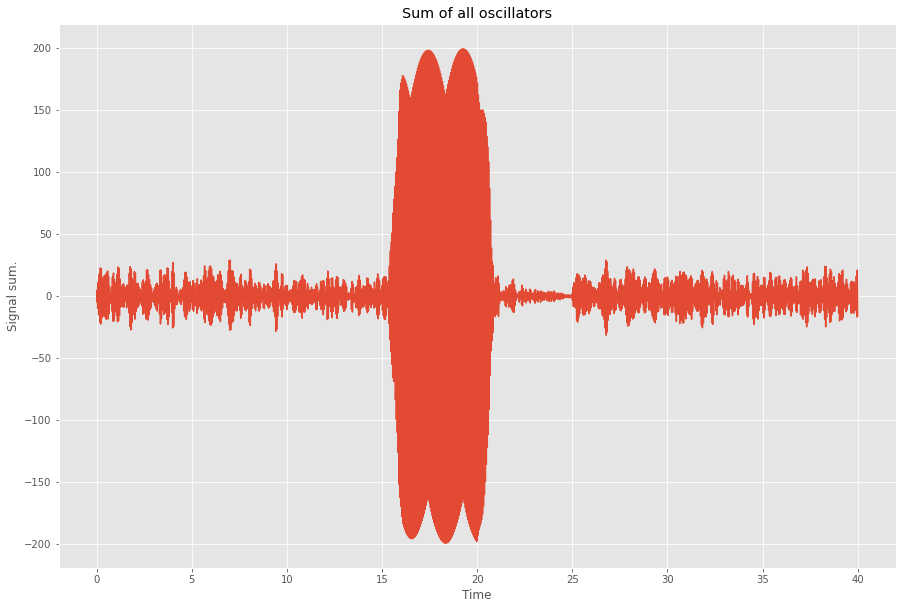

In [ ]:
if completeTimeFlag:
    plt.figure(figsize=(15,10))
    sumSignal = sumOsc(odePhi, A)
    plt.plot(times, sumSignal)
    plt.xlabel('Time')
    plt.ylabel('Signal sum.')
    plt.title("Sum of all oscillators");

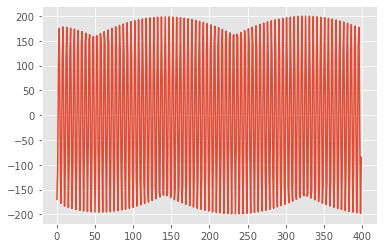

In [ ]:
plt.figure()
sumSignal = sumOsc(odePhi, A)
sig = sumSignal[1600:2000]
plt.plot(sig)

# Figure 3a.2

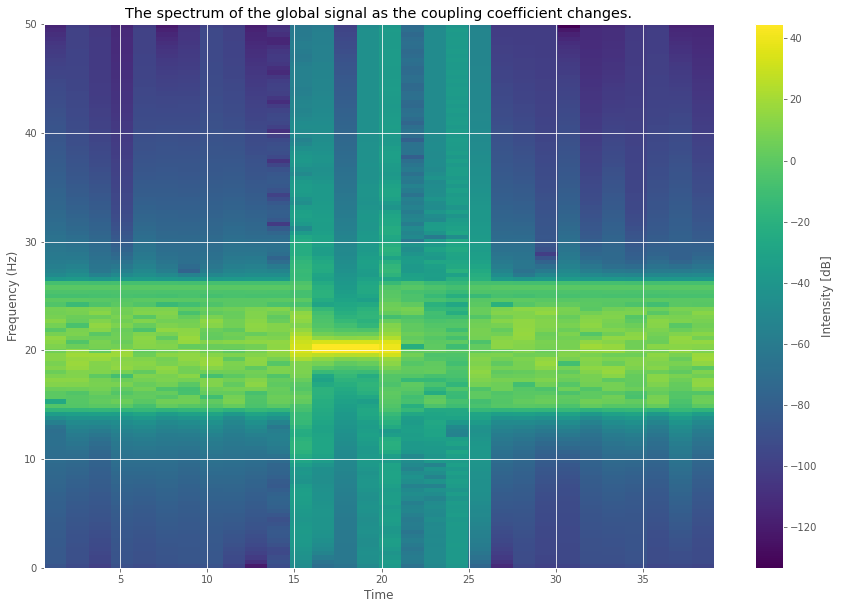

In [ ]:
fig=plt.figure(figsize=(15,10))
pxx,  freq, t, cax = plt.specgram(sumSignal, Fs=100);
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
fig.colorbar(cax).set_label('Intensity [dB]')
plt.title('The spectrum of the global signal as the coupling coefficient changes.');

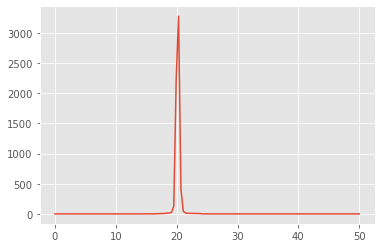

In [ ]:
f, psd = welch(sumSignal, fs=100)
plt.plot(f,psd);

In [ ]:
parameterList = []
solution_times=tfp.math.ode.ChosenBySolver(final_time=10)
ode_fn = kuramoto_ODE_tf
jacobian_fn = kuramoto_jac_tf
    
for k in np.linspace(1,100,1001):
    K_tf = tf.constant(k * tf.eye(nOsc, dtype=tf.double))
    results = tfp.math.ode.BDF().solve(ode_fn=ode_fn, 
                                initial_time=0, 
                                initial_state=Y0, 
                                solution_times=solution_times, 
                                jacobian_fn=jacobian_fn)
    
    odePhi = results.states.numpy().T
    finalOrderParamter = np.abs(np.exp(odePhi[:,-1] * (0+1j)).sum())
    parameterList.append(finalOrderParamter)

# Figure 3b

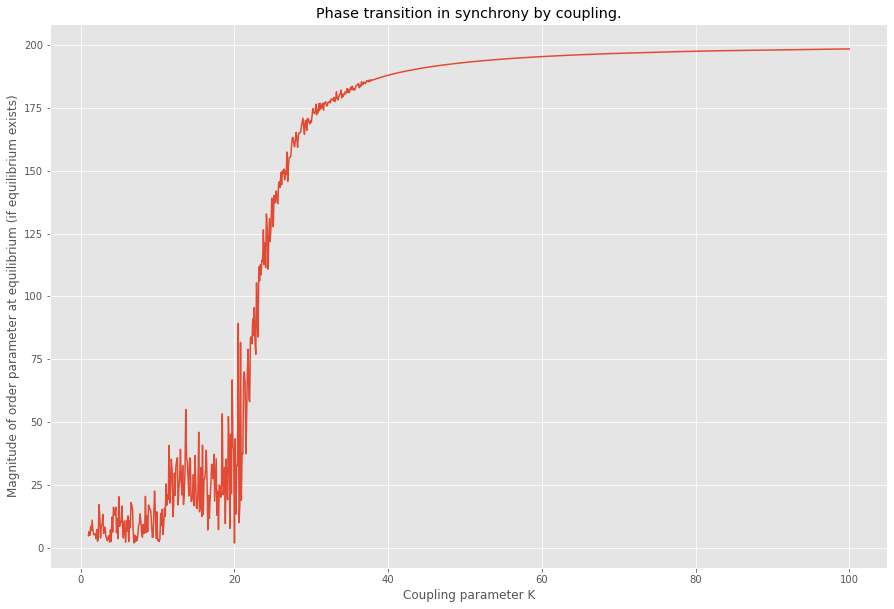

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(np.linspace(1,100,1001),parameterList)
plt.xlabel('Coupling parameter K')
plt.ylabel('Magnitude of order parameter at equilibrium (if equilibrium exists)')
plt.title('Phase transition in synchrony by coupling.');

In [ ]:
orderParameterMatrix = []
solution_times=tfp.math.ode.ChosenBySolver(final_time=10)
ode_fn = kuramoto_ODE_tf
jacobian_fn = kuramoto_jac_tf
    
for sigma in np.linspace(1,10,91):
    print(sigma)
    newRow = []
    W_tf = tf.constant(2 * np.pi * np.random.normal(loc=20, scale=sigma, size=nOsc), dtype=tf.double)
    for k in range(1,101):
        K_tf = tf.constant(k * tf.eye(nOsc, dtype=tf.double))
        results = tfp.math.ode.BDF().solve(ode_fn=ode_fn, 
                                    initial_time=0, 
                                    initial_state=Y0, 
                                    solution_times=solution_times, 
                                    jacobian_fn=jacobian_fn)

        odePhi = results.states.numpy().T
        finalOrderParamter = np.abs(np.exp(odePhi[:,-1] * (0+1j)).sum())
        newRow.append(finalOrderParamter)
    orderParameterMatrix.append(newRow)
    
orderParameterMatrix = np.array(orderParameterMatrix)

# Figure 3c

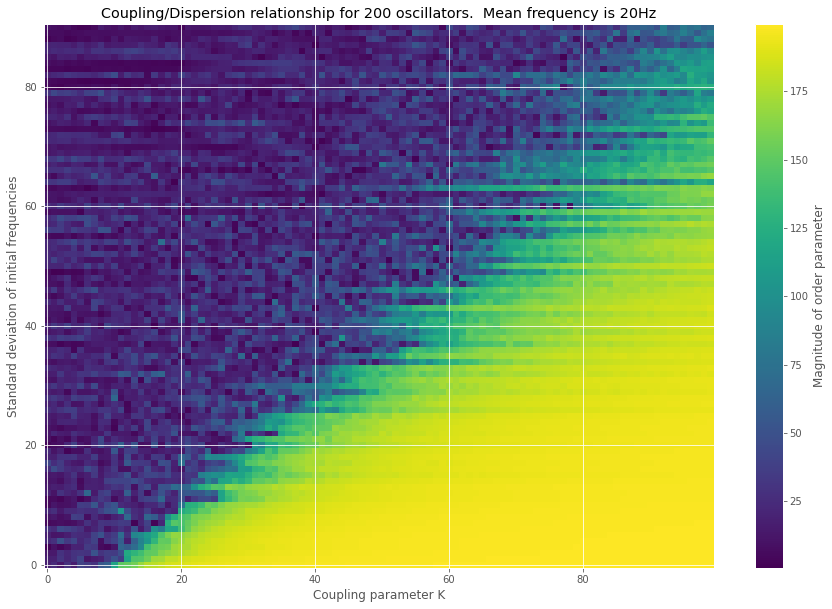

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(orderParameterMatrix, aspect='auto', origin='lower')
plt.xlabel('Coupling parameter K')
plt.ylabel('Standard deviation of initial frequencies')
plt.colorbar().set_label('Magnitude of order parameter')
plt.title('Coupling/Dispersion relationship for 200 oscillators.  Mean frequency is 20Hz');

# Scratch